# Multi-Layer Perceptron (Neural Network)
## Research Question: "Predict whether a stop and search will conclude in police action".

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv), and a Multilayer Perceptron.

NOTE: Most models tested have been saved as .h5 files, inside src/models. Find a tabulation of all tested models, and their confusion matrices, inside: 
- src/models/Models tested.pdf 
- src/models/Confusion Matrix

### Import libraries 

NOTICE: the Imbalance-learn library is used, in addition to the libraries covered in class. You'll need to "pip install imbalanced-learn" to run this notebook. 
https://pypi.org/project/imbalanced-learn/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.utils import to_categorical

from os.path import exists
import util_smote as usm
import util

#SMOTE
from imblearn.over_sampling import SMOTE


Using TensorFlow backend.


## Helper Functions

Two helper functions. One to help with training, the second to help with evaluation.

### train_nn

The function takes in
- a model
- the path to the model on the file system (or the path you wish the model to be saved to)
- the X train and y_train sets
- epochs, the number of epochs you wish to train the nueral network for before saving it to the path
- eras, the number of times you wish to repeat the training process, saving after each is complete.

For example: if "eras" is set to 2, and "epochs" to 100, the network will train for 100 epochs, save to the file system, then train for another 100 epochs, then save to the file system again.

This process was concoted because we encountered situations where Jupyter crashed while training, and we had to start all over again. This ensures that progress is automatically saved for us.

### evaluate_nn

One helper function to help with the evaluation process. Takes in the model, the X and y train/test, and ouputs:
- Accuracy on test
- Precision test
- Matthews Correlation Coefficient on train and test
- Confusion Matrix on test

In [2]:
# A function that takes in a model and trains it
def train_nn(model, path, X_train, y_train, eras=1, epochs=100, min_delta=0.0001, min_lr=0.0000001, stoping_patience=4, lr_patience=2):
    #One-Hot-encode y_train
    y_encoded = to_categorical(y_train)
    #Early Stopping callback- from ex7Part1 (lab 7 of Intro to AI module)
    early_stopping = EarlyStopping(monitor='loss', min_delta=min_delta, patience=stoping_patience, verbose=1)
    #Reduce learning rate callbck - from https://keras.io/api/callbacks/reduce_lr_on_plateau/ 
    reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=lr_patience, min_lr=min_lr, verbose=1)
    for i in range(eras):
        print(f"Starting era {i}...")
        if exists(path):
            print("🚨 Model alredy exists!")
            print("Loading model...")
            del model
            model = load_model(path)
        model.fit(X_train, y_encoded, epochs=epochs, callbacks=[reduce_learning_rate, early_stopping])
        model.save(path)

# A function that takes in a model and evaluates it
def evaluate_nn(model, path, X_test, y_test, X_train, y_train, target_classes=["0", "1", "2", "3", "4", "5", "6", "7"], average='weighted', binary=False, rotation=0, fontsize=24):
    del model
    model = load_model(path)
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    pred_train = model.predict(X_train)
    pred_train = np.argmax(pred_train, axis=1)

    y_encoded = to_categorical(y_test)
    y_encoded_train = to_categorical(y_train)
    y_comparison = np.argmax(y_encoded, axis=1)
    y_comparison_train = np.argmax(y_encoded_train, axis=1)

    accuracy = metrics.accuracy_score(y_comparison, pred)
    precision = metrics.precision_score(y_comparison, pred, average=average)
    matthew_coef_test = metrics.matthews_corrcoef(y_comparison, pred)
    matthew_coef_train = metrics.matthews_corrcoef(y_comparison_train, pred_train)
    print(f"\nAccuracy is {accuracy * 100}")
    print(f"\nPrecision is {precision * 100}")
    print(f"\nMCC test: {matthew_coef_test}")
    print(f"MCC train: {matthew_coef_train}")
    #Confusion Matrix
    util.confusion_plot(y_test=y_comparison, y_predictions=pred, target_classes=target_classes, rotation=rotation, fontsize=fontsize)


## Cleaning the Data

In [3]:
data = pd.read_csv("data.csv")
data = util.data_cleaner(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Data

In [4]:
data_encoded, encoders = util.data_encoder(data)
outcome_classes = encoders["Outcome Encoder"].classes_
data_encoded.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


## Splitting the Data

In [5]:
#Splt into X and y, while one-hot-encoding the target

target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)

# Split into features and target
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

## The MLP

We start with a basic MLP:
- Input
- Hidden (9 unit, relu activation)
- Output (8 unit, softmax)

### Build

In [6]:
simple_model = Sequential()
simple_model.add(Dense(9, input_dim=9, activation='relu'))
simple_model.add(Dense(8, activation='softmax'))
simple_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [7]:
%%time

model_name = "simple(9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(simple_model, path=path, X_train=X_train, y_train=y_train, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)

Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/100
4142/4142 [==============================] - 2s 437us/step - loss: 1.0164
Epoch 2/100
4142/4142 [==============================] - 2s 460us/step - loss: 1.0164
Epoch 3/100
4088/4142 [============================>.] - ETA: 0s - loss: 1.0166
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 431us/step - loss: 1.0164
Epoch 4/100
4142/4142 [==============================] - 2s 422us/step - loss: 1.0164
Epoch 5/100
4139/4142 [============================>.] - ETA: 0s - loss: 1.0164
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 425us/step - loss: 1.0164
Epoch 6/100
4142/4142 [==============================] - 2s 435us/step - loss: 1.0164
Epoch 7/100
4035/4142 [============================>.] - ETA: 0s - loss: 1.0160
Epoch 00007: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [=======

### Evaluate


Accuracy is 63.354562192508524

Precision is 48.86747614633008

MCC test: -0.002410454098745512
MCC train: -0.0034334519859737004


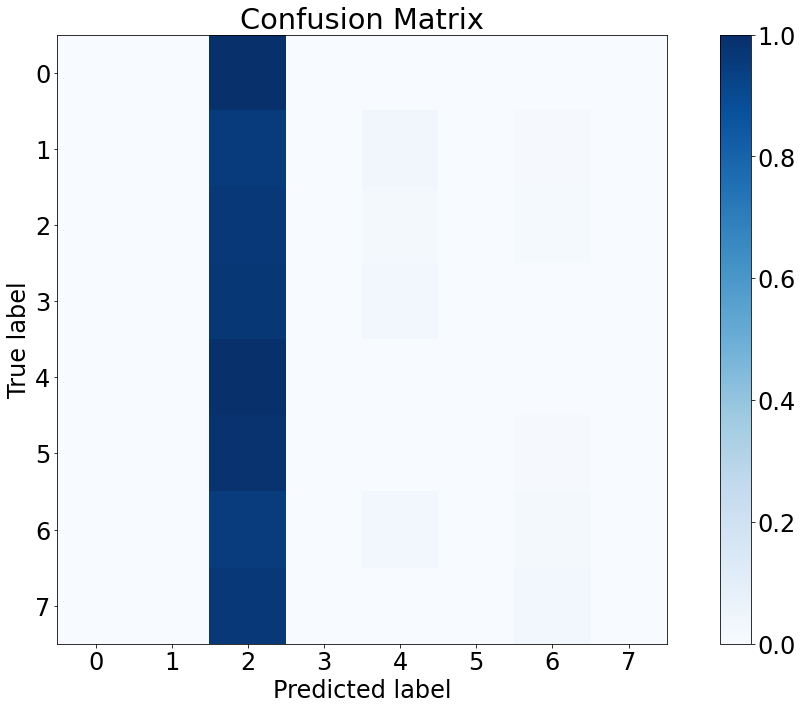

In [8]:
evaluate_nn(model=simple_model, path=path, X_test=X_test, y_test=y_test, X_train=X_train, y_train=y_train)

The model was able to predict test set 63% of the time. It is highly biased to predict class 2 ("Nothing found - no further action"), suggesting an underfit of the data.

## Adding More Hidden Layers

We try to add more layers to alleviate the underfitting of our model

### Build

In [9]:
model_more_hidden = Sequential()
model_more_hidden.add(Dense(9, input_dim=9, activation='relu')) # Hidden 1
model_more_hidden.add(Dense(9, activation='relu')) # Hidden 2
model_more_hidden.add(Dense(9, activation='relu')) # Hidden 3
model_more_hidden.add(Dense(8, activation='softmax')) # Ouput
model_more_hidden.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [10]:
%%time

model_name = "simple(9_9_9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(model_more_hidden, path=path, X_train=X_train, y_train=y_train, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)

Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/100
4142/4142 [==============================] - 2s 530us/step - loss: 1.0035
Epoch 2/100
4142/4142 [==============================] - 2s 515us/step - loss: 1.0035
Epoch 3/100
4135/4142 [============================>.] - ETA: 0s - loss: 1.0034
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 499us/step - loss: 1.0035
Epoch 4/100
4142/4142 [==============================] - 2s 498us/step - loss: 1.0035
Epoch 5/100
4113/4142 [============================>.] - ETA: 0s - loss: 1.0034
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 513us/step - loss: 1.0035
Epoch 00005: early stopping
CPU times: user 18.5 s, sys: 9.72 s, total: 28.2 s
Wall time: 10.9 s



Accuracy is 65.1082068153693

Precision is 57.39694396795231

MCC test: 0.010208085324035237
MCC train: 0.008375152228069234


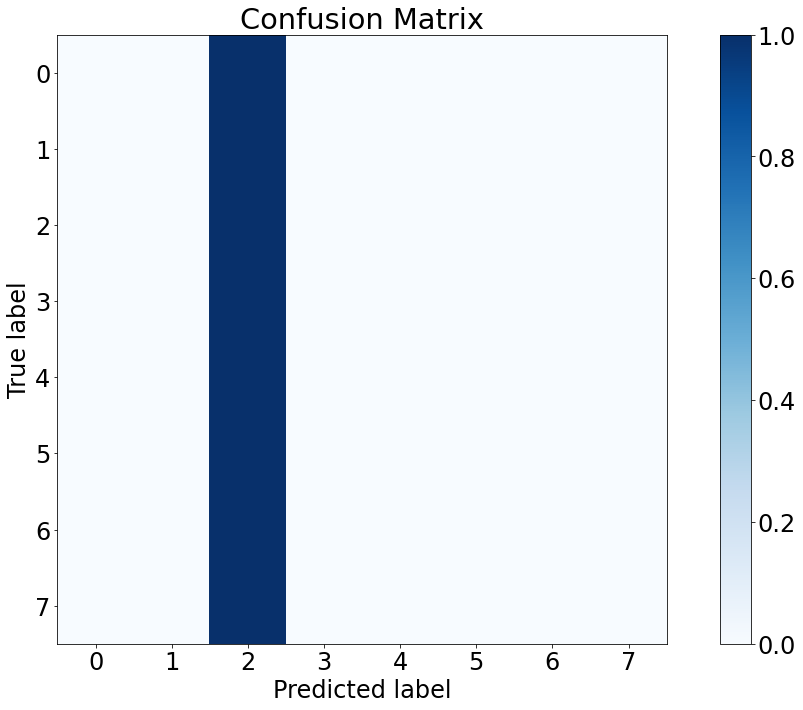

In [11]:
evaluate_nn(model=model_more_hidden, path=path, X_test=X_test, y_test=y_test, X_train=X_train, y_train=y_train)

Accuracy not signficantly improved... however, precision has increased.

# Sigmoid Activation

Let's try using sigmid instead of relu as our activation

### Build

In [12]:
sigmoid_model = Sequential()
sigmoid_model.add(Dense(9, input_dim=9, activation='sigmoid')) # Hidden 1
sigmoid_model.add(Dense(9, activation='sigmoid')) # Hidden 2
sigmoid_model.add(Dense(9, activation='sigmoid')) # Hidden 3
sigmoid_model.add(Dense(8, activation='softmax')) # Ouput
sigmoid_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [13]:
%%time

model_name = "sigmoid(9_9_9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(sigmoid_model, path=path, X_train=X_train, y_train=y_train, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)

Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/100
4142/4142 [==============================] - 2s 502us/step - loss: 1.0039
Epoch 2/100
4142/4142 [==============================] - 2s 493us/step - loss: 1.0039
Epoch 3/100
4057/4142 [============================>.] - ETA: 0s - loss: 1.0040
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 508us/step - loss: 1.0039
Epoch 4/100
4142/4142 [==============================] - 2s 525us/step - loss: 1.0039
Epoch 5/100
4068/4142 [============================>.] - ETA: 0s - loss: 1.0040
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 519us/step - loss: 1.0039
Epoch 00005: early stopping
CPU times: user 18.5 s, sys: 9.51 s, total: 28 s
Wall time: 10.8 s


### Evaluate


Accuracy is 65.1021701729498

Precision is 42.38292561227715

MCC test: 0.0
MCC train: 0.0


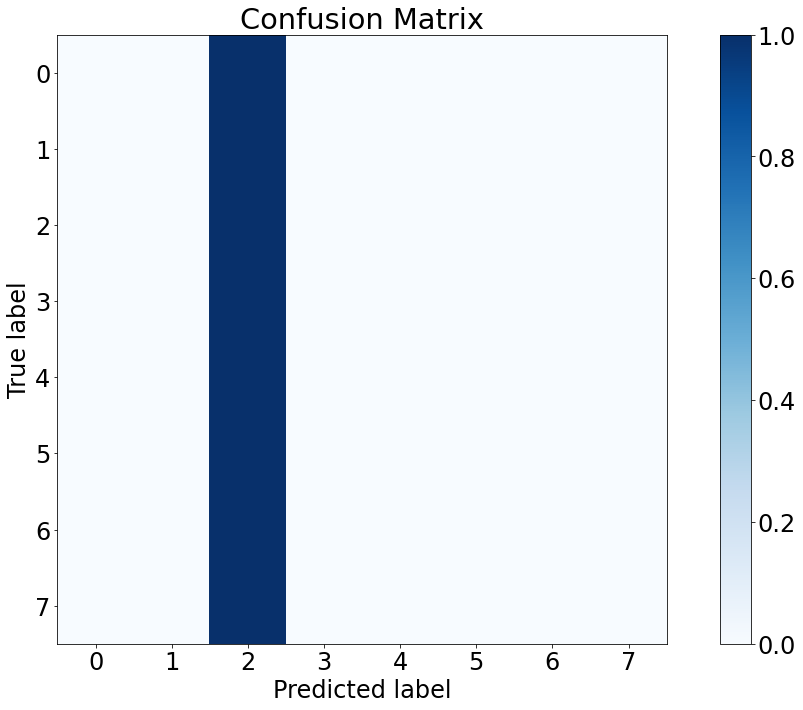

In [14]:
evaluate_nn(model=sigmoid_model, path=path, X_test=X_test, y_test=y_test, X_train=X_train, y_train=y_train)

Results worse. Relu is the superior activation function for that architecture.

# Using SMOTE 

The issue seems to be that a single class dominates the other classes by far in terms of frequency.

Class 0: 0.02%     (41)
Class 1: 0.68%     (1121)
Class 2: 65.41%     (108353)
Class 3: 0.1%     (167)
Class 4: 10.74%     (17788)
Class 5: 2.31%     (3824)
Class 6: 19.96%     (33067)
Class 7: 0.78%     (1290)
Total: 165651


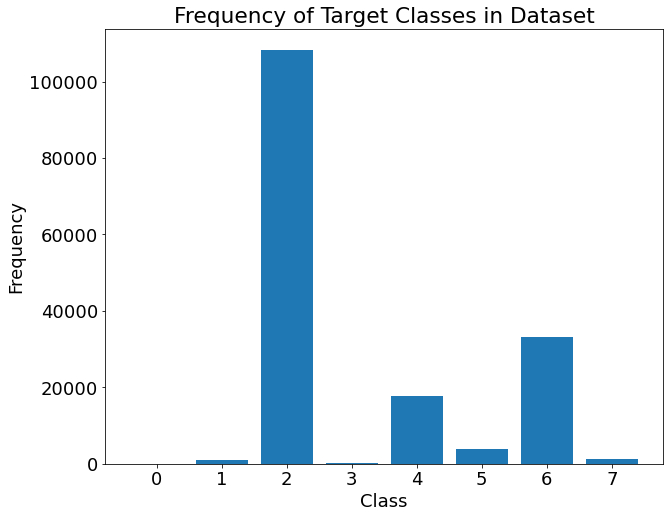

In [15]:
#The frequencies of each class in the dataset
usm.display_frequencies(data_encoded["Outcome"])

65% of the example targets belong to class 2! 

We can solve this by using SMOTE to generate artificial data for our minor classes.

### Preprocessing

Class 0: 12.5%     (86784)
Class 1: 12.5%     (86784)
Class 2: 12.5%     (86784)
Class 3: 12.5%     (86784)
Class 4: 12.5%     (86784)
Class 5: 12.5%     (86784)
Class 6: 12.5%     (86784)
Class 7: 12.5%     (86784)
Total: 694272


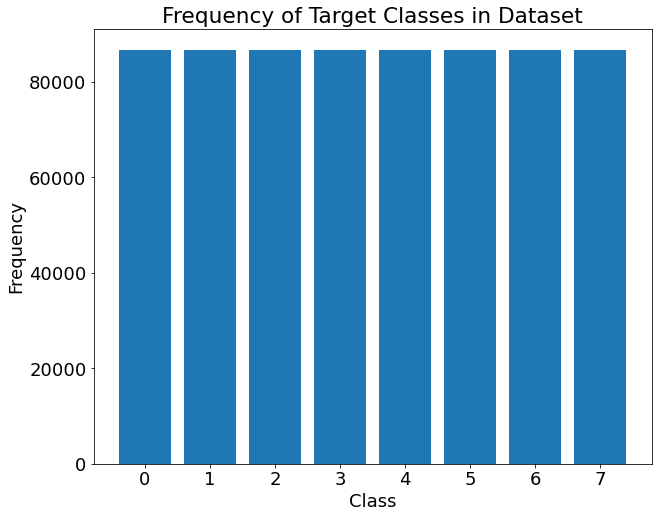

In [16]:
X_smote, y_smote = usm.smote_data(X_train, y_train)
y_encoded = to_categorical(y_smote)
usm.display_frequencies(y_smote)


After using SMOTE, the frequencies of each class have been equalized.

We can begin training now...

### Build Model

In [17]:
smote_model = Sequential()
smote_model.add(Dense(64, input_dim=9, activation='relu'))
for i in range(10):
    smote_model.add(Dense(64, activation='relu'))
smote_model.add(Dense(8, activation='softmax')) # Ouput
smote_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [18]:
%%time
model_name = "smoted(9_9_9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(smote_model, path=path, X_train=X_smote, y_train=y_smote, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)


Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/100
21696/21696 [==============================] - 11s 499us/step - loss: 2.0741
Epoch 2/100
21696/21696 [==============================] - 11s 501us/step - loss: 2.0741
Epoch 3/100
21630/21696 [============================>.] - ETA: 0s - loss: 2.0741
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-07.
21696/21696 [==============================] - 11s 499us/step - loss: 2.0741
Epoch 4/100
21696/21696 [==============================] - 11s 502us/step - loss: 2.0741
Epoch 5/100
21614/21696 [============================>.] - ETA: 0s - loss: 2.0741
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-07.
21696/21696 [==============================] - 11s 500us/step - loss: 2.0741
Epoch 00005: early stopping
CPU times: user 1min 33s, sys: 51.8 s, total: 2min 25s
Wall time: 54.6 s


### Evaluate


Accuracy is 0.14186109685792764

Precision is 36.720888939837586

MCC test: -0.0007074870316161497
MCC train: 0.0027749496365950606


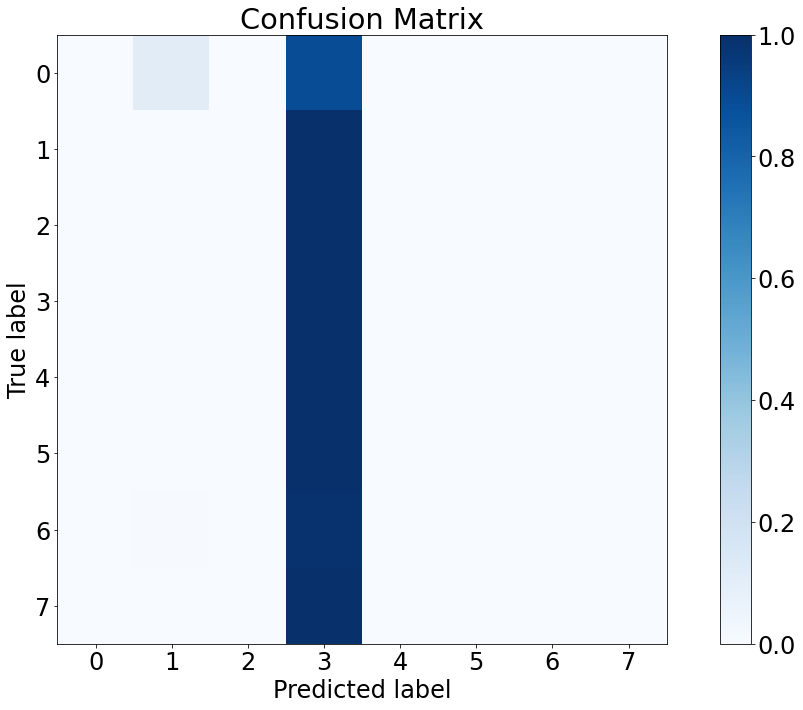

In [19]:
evaluate_nn(model=smote_model, path=path, X_test=X_test, y_test=y_test, X_train=X_train, y_train=y_train)

Accuracy is obviously much worse, but the model is not blindly selecting the majority class anymore. Given the increased size of the data (added aritifical data), we try a large network.

## SMOTE (Playground)

We try different architectures here.

In [20]:
smote_model = Sequential()

smote_model.add(Dense(64, input_dim=9, activation='relu'))
for i in range(9):
    smote_model.add(Dense(64, activation='relu'))
smote_model.add(Dense(8, activation='softmax'))
smote_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [21]:
%%time
model_name = "model(9_64x10_8)"
path = f"./models/{model_name}.h5"

train_nn(smote_model, path=path, X_train=X_smote, y_train=y_smote, eras=1, epochs=95, min_delta=0.0001, min_lr=1e-10, stoping_patience=4, lr_patience=2)

Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/95
21696/21696 [==============================] - 20s 902us/step - loss: 1.8026 - accuracy: 0.2963
Epoch 2/95
21696/21696 [==============================] - 20s 927us/step - loss: 1.8026 - accuracy: 0.2962
Epoch 3/95
21662/21696 [============================>.] - ETA: 0s - loss: 1.8025 - accuracy: 0.2963
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.000000023372195e-08.
21696/21696 [==============================] - 20s 936us/step - loss: 1.8026 - accuracy: 0.2962
Epoch 4/95
21696/21696 [==============================] - 20s 915us/step - loss: 1.8026 - accuracy: 0.2962
Epoch 5/95
21688/21696 [============================>.] - ETA: 0s - loss: 1.8025 - accuracy: 0.2962
Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.999999975690117e-09.
21696/21696 [==============================] - 20s 931us/step - loss: 1.8026 - accuracy: 0.2962
Epoch 00005: early stopping
CPU times: user 4min 32s, sys: 3min 57s, 


Accuracy is 4.3101626875132055

Precision is 49.33576412581906

MCC test: 0.005107575788638504
MCC train: 0.0057261161555899115


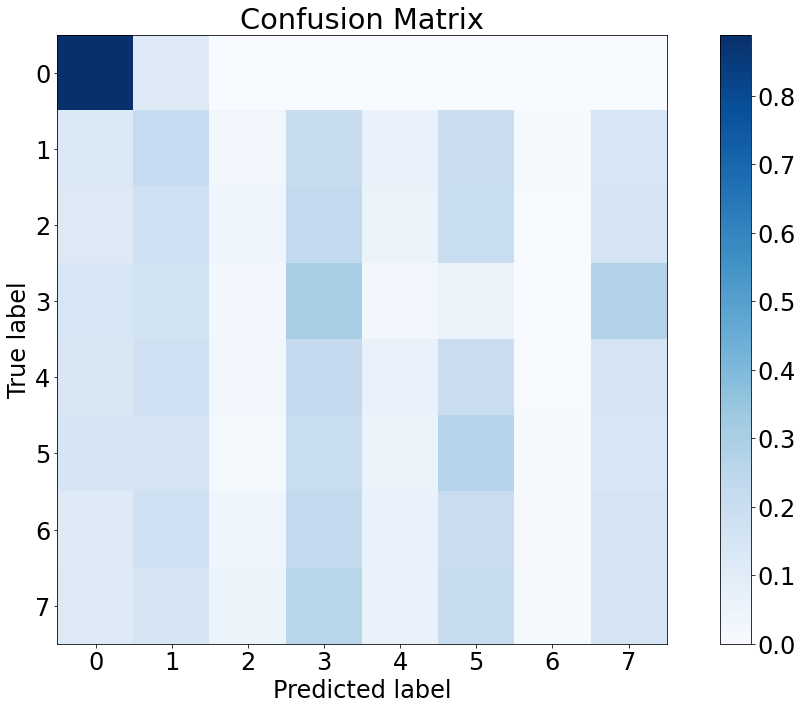

In [22]:
evaluate_nn(model=smote_model, path=path, X_test=X_test, y_test=y_test, X_train=X_train, y_train=y_train)

## Using Scaled Data

We try scaling the data using the StandardScaler(), as well as the MinMaxScaler()- after adding artifical samples using SMOTE. Scaling the data yielded signficantly better results with the single perceptron, we hypothesize that it may help with the neural network as well.

In [23]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
X_scaled = pd.DataFrame(features_scaled, columns=data.drop("Outcome", axis=1).columns)

X_scaled.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search
0,0.641784,-1.720167,0.031037,0.055872,0.265176,0.379816,-1.346153,1.233580,7.911489
1,0.641784,-1.720167,0.031037,0.055872,0.265176,0.379816,-1.346153,1.233580,7.911489
2,0.641784,-1.720133,0.031037,0.055872,0.265176,0.379816,1.062035,1.233580,7.911489
3,-1.526923,-1.720099,0.031037,0.055872,0.265176,0.379816,1.062035,1.233580,7.911489
4,0.641784,-1.720065,0.031037,0.055872,0.265176,0.379816,-1.346153,-0.453747,0.417036


In [24]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, target, test_size=0.2, random_state=10)
X_smote_scaled, y_smote_scaled = usm.smote_data(X_train_scaled, y_train_scaled)

### Build the model

In [25]:
scaled_model = Sequential()

scaled_model.add(Dense(9, input_dim=9, activation='relu'))
scaled_model.add(Dropout(0.04))
scaled_model.add(Dense(60, activation='relu'))
for i in range(7):
    scaled_model.add(Dense(256, activation='relu'))
scaled_model.add(Dense(8, activation='softmax'))
scaled_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [26]:
%%time
model_name = "scaled(9_dropout(0.04)_60_256x7_8)"
path = f"./models/{model_name}.h5"

train_nn(scaled_model, path=path, X_train=X_smote_scaled, y_train=y_smote_scaled, eras=1, epochs=95, min_delta=0.0001, min_lr=1e-10, stoping_patience=4, lr_patience=2)

Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/95
21696/21696 [==============================] - 38s 2ms/step - loss: 0.8839
Epoch 2/95
21696/21696 [==============================] - 38s 2ms/step - loss: 0.8791
Epoch 3/95
21696/21696 [==============================] - 38s 2ms/step - loss: 0.8767
Epoch 4/95
21696/21696 [==============================] - 38s 2ms/step - loss: 0.8765
Epoch 5/95
21696/21696 [==============================] - 38s 2ms/step - loss: 0.8797
Epoch 6/95
21673/21696 [============================>.] - ETA: 0s - loss: 0.8859
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
21696/21696 [==============================] - 36s 2ms/step - loss: 0.8859
Epoch 7/95
21696/21696 [==============================] - 36s 2ms/step - loss: 0.8750
Epoch 8/95
21696/21696 [==============================] - 36s 2ms/step - loss: 0.8777
Epoch 9/95
21681/21696 [============================>.] - ETA: 0s - loss: 0.8781
Epoch 00009: ReduceLRO

### Evaluate


Accuracy is 21.167486643928648

Precision is 52.479691731273384

MCC test: 0.05936269214044086
MCC train: 0.16887601745097724


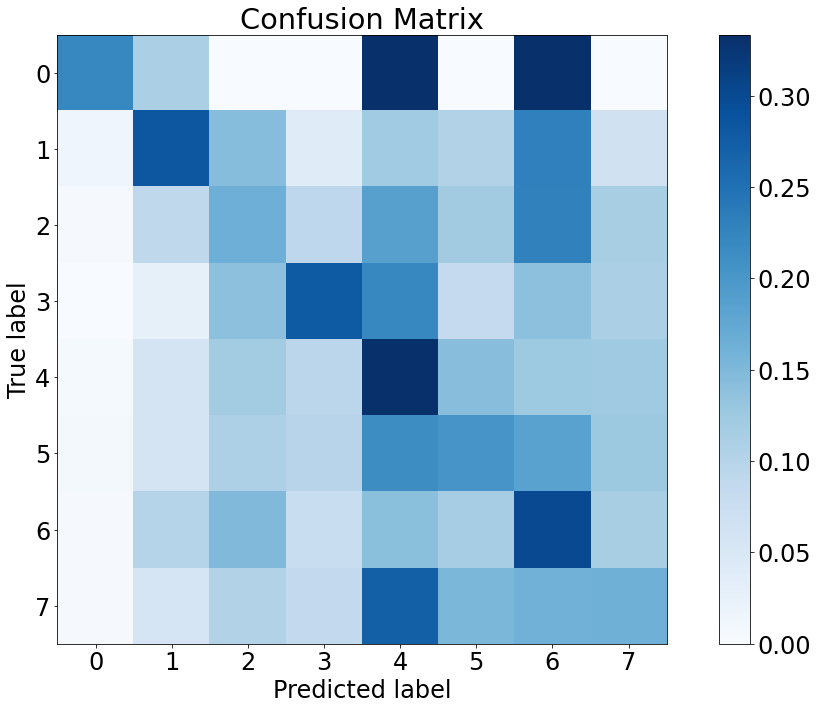

In [27]:
evaluate_nn(model=smote_model, path=path, X_test=X_test_scaled, y_test=y_test_scaled, X_train=X_train_scaled, y_train=y_train_scaled)

## Adding L1/L2 Regularization

We try various regularization techniques to help reduce the overfitting of our models. 

In [28]:
reg_model = Sequential()

reg_model.add(Dense(350, input_dim=9, activation='relu', kernel_regularizer=regularizers.l2(0.03)))
reg_model.add(Dropout(0.04))
for i in range(3):
    reg_model.add(Dense(350, activation='relu'))
reg_model.add(Dense(8, activation='softmax'))
reg_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [29]:
%%time
model_name = "regL1(350(reg_l2_0.03)_dropout(0.04)_350x3_8)"
path = f"./models/{model_name}.h5"

train_nn(reg_model, path=path, X_train=X_smote_scaled, y_train=y_smote_scaled, eras=1, epochs=95, min_delta=0.0001, min_lr=1e-10, stoping_patience=4, lr_patience=2)

Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/95
21696/21696 [==============================] - 27s 1ms/step - loss: 0.8207
Epoch 2/95
21696/21696 [==============================] - 27s 1ms/step - loss: 0.8207
Epoch 3/95
21663/21696 [============================>.] - ETA: 0s - loss: 0.8207
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.5600002118153498e-09.
21696/21696 [==============================] - 27s 1ms/step - loss: 0.8207
Epoch 4/95
21696/21696 [==============================] - 28s 1ms/step - loss: 0.8207
Epoch 5/95
21676/21696 [============================>.] - ETA: 0s - loss: 0.8212
Epoch 00005: ReduceLROnPlateau reducing learning rate to 5.1200004236307e-10.
21696/21696 [==============================] - 31s 1ms/step - loss: 0.8212
Epoch 00005: early stopping
CPU times: user 9min 38s, sys: 2min 41s, total: 12min 20s
Wall time: 2min 21s



Accuracy is 25.818719628142826

Precision is 53.28113894833455

MCC test: 0.07299877316860923
MCC train: 0.24318445109959935


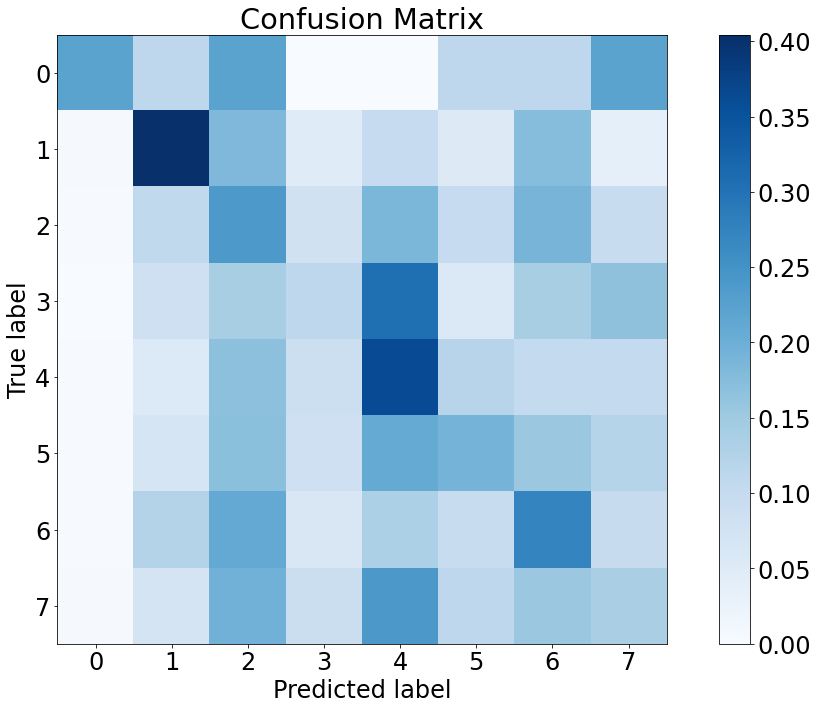

In [30]:
evaluate_nn(model=reg_model, path=path, X_test=X_test_scaled, y_test=y_test_scaled, X_train=X_train_scaled, y_train=y_train_scaled)